In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [2]:
def get_datetime_id():
    return datetime.datetime.now().strftime('%h-%d-%y_%H-%M-00')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Unzip files that we need

In [4]:
!unzip /content/drive/MyDrive/cbis-ddsm-zips/calc_only.zip -d /content/cbis-ddsm/

Streaming output truncated to the last 5000 lines.
 extracting: /content/cbis-ddsm/train/MALIGNANT_CALCIFICATION/1.3.6.1.4.1.9590.100.1.2.155046609013709176715670803564130273583-1.3.6.1.4.1.9590.100.1.2.391876226111657492320851639130860760300-abnorm_2-patch_4.png  
 extracting: /content/cbis-ddsm/train/MALIGNANT_CALCIFICATION/1.3.6.1.4.1.9590.100.1.2.428568107012220982611548240900352369745-1.3.6.1.4.1.9590.100.1.2.228185298612585162903917687442444219459-abnorm_1-patch_0.png  
 extracting: /content/cbis-ddsm/train/MALIGNANT_CALCIFICATION/1.3.6.1.4.1.9590.100.1.2.40355986812557976241479075134049499050-1.3.6.1.4.1.9590.100.1.2.315126228411546505434859462891780436839-abnorm_1-patch_6.png  
 extracting: /content/cbis-ddsm/train/MALIGNANT_CALCIFICATION/1.3.6.1.4.1.9590.100.1.2.299050269611436822102138604901211017517-1.3.6.1.4.1.9590.100.1.2.127896422011431355705216667061075429849-abnorm_2-patch_0.png  
 extracting: /content/cbis-ddsm/train/MALIGNANT_CALCIFICATION/1.3.6.1.4.1.9590.100.1.2.559

In [5]:
IMG_SIZE = (224, 224)
IMG_SHAPE = (IMG_SIZE + (3,))
BATCH_SIZE = 100

In [6]:
data_dir = '/content/cbis-ddsm/train/'
ds_train = tf.keras.preprocessing.image_dataset_from_directory(data_dir,
                                                               image_size=(224,224),
                                                               batch_size=BATCH_SIZE)

Found 14130 files belonging to 2 classes.


In [7]:
data_dir = '/content/cbis-ddsm/valid/'
ds_valid = tf.keras.preprocessing.image_dataset_from_directory(data_dir,
                                                               image_size=(224,224),
                                                               batch_size=BATCH_SIZE)

Found 1700 files belonging to 2 classes.


In [8]:
num_classes = len(ds_train.class_names)
BUFFER_SIZE = 250
STEPS_PER_EPOCH = 20 

In [9]:
train_dataset = ds_train.cache().shuffle(BUFFER_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
valid_dataset = ds_valid.cache()
valid_dataset = valid_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

Transfer Learning Binary Classification

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
# Freeze convolution base
base_model.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  #tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
])
# go from 0,255 to -1,1
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1)

In [ ]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
#x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001/10
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics='accuracy')

In [ ]:
class CollectBatchStats(tf.keras.callbacks.Callback):
    def __init__(self):
        self.batch_losses = []
        self.batch_acc = []

    def on_train_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['accuracy'])
        self.model.reset_metrics()

batch_stats_callback = CollectBatchStats()

In [ ]:
initial_epochs = 60
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=valid_dataset,
                    callbacks=[batch_stats_callback])

Epoch 1/60
20/20 [==============================] - 66s 538ms/step - loss: 0.7864 - accuracy: 0.6333 - val_loss: 0.7720 - val_accuracy: 0.6529
Epoch 2/60
20/20 [==============================] - 4s 226ms/step - loss: 0.7833 - accuracy: 0.6267 - val_loss: 0.7571 - val_accuracy: 0.6529
Epoch 3/60
20/20 [==============================] - 4s 227ms/step - loss: 0.7476 - accuracy: 0.6410 - val_loss: 0.7442 - val_accuracy: 0.6529
Epoch 4/60
20/20 [==============================] - 4s 226ms/step - loss: 0.7325 - accuracy: 0.6481 - val_loss: 0.7331 - val_accuracy: 0.6529
Epoch 5/60
20/20 [==============================] - 4s 227ms/step - loss: 0.7420 - accuracy: 0.6329 - val_loss: 0.7231 - val_accuracy: 0.6535
Epoch 6/60
20/20 [==============================] - 4s 227ms/step - loss: 0.7143 - accuracy: 0.6457 - val_loss: 0.7145 - val_accuracy: 0.6535
Epoch 7/60
20/20 [==============================] - 5s 243ms/step - loss: 0.7084 - accuracy: 0.6389 - val_loss: 0.7077 - val_accuracy: 0.6535
Epoch

Fine Tuning

In [ ]:
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics='accuracy')

In [ ]:
fine_tune_epochs = 60
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         steps_per_epoch=STEPS_PER_EPOCH,
                         initial_epoch=history.epoch[-1],
                         validation_data=valid_dataset,
                         callbacks=[batch_stats_callback])

Epoch 60/120
20/20 [==============================] - 10s 321ms/step - loss: 0.6289 - accuracy: 0.6386 - val_loss: 0.6383 - val_accuracy: 0.6524
Epoch 61/120
20/20 [==============================] - 6s 285ms/step - loss: 0.6302 - accuracy: 0.6338 - val_loss: 0.6357 - val_accuracy: 0.6524
Epoch 62/120
20/20 [==============================] - 6s 285ms/step - loss: 0.6125 - accuracy: 0.6452 - val_loss: 0.6212 - val_accuracy: 0.6559
Epoch 63/120
20/20 [==============================] - 6s 285ms/step - loss: 0.6053 - accuracy: 0.6400 - val_loss: 0.6187 - val_accuracy: 0.6535
Epoch 64/120
20/20 [==============================] - 6s 293ms/step - loss: 0.6021 - accuracy: 0.6403 - val_loss: 0.6188 - val_accuracy: 0.6565
Epoch 65/120
20/20 [==============================] - 6s 287ms/step - loss: 0.6081 - accuracy: 0.6362 - val_loss: 0.6174 - val_accuracy: 0.6606
Epoch 66/120
20/20 [==============================] - 6s 286ms/step - loss: 0.5767 - accuracy: 0.6595 - val_loss: 0.6053 - val_accuracy

Fine Tuning 2

In [ ]:
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 50

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/100),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics='accuracy')

In [ ]:
fine_tune_epochs = 60
total_epochs =  total_epochs + fine_tune_epochs

history_fine2 = model.fit(train_dataset,
                         epochs=total_epochs,
                         steps_per_epoch=STEPS_PER_EPOCH,
                         initial_epoch=history_fine.epoch[-1],
                         validation_data=valid_dataset,
                         callbacks=[batch_stats_callback])

Epoch 120/180
20/20 [==============================] - 11s 380ms/step - loss: 0.5065 - accuracy: 0.7086 - val_loss: 0.5640 - val_accuracy: 0.7059
Epoch 121/180
20/20 [==============================] - 7s 340ms/step - loss: 0.5058 - accuracy: 0.7271 - val_loss: 0.5667 - val_accuracy: 0.7094
Epoch 122/180
20/20 [==============================] - 7s 341ms/step - loss: 0.4958 - accuracy: 0.7319 - val_loss: 0.5628 - val_accuracy: 0.7059
Epoch 123/180
20/20 [==============================] - 7s 341ms/step - loss: 0.5060 - accuracy: 0.7138 - val_loss: 0.5582 - val_accuracy: 0.7071
Epoch 124/180
20/20 [==============================] - 7s 341ms/step - loss: 0.5126 - accuracy: 0.7100 - val_loss: 0.5608 - val_accuracy: 0.7082
Epoch 125/180
20/20 [==============================] - 7s 337ms/step - loss: 0.5016 - accuracy: 0.7279 - val_loss: 0.5627 - val_accuracy: 0.7082
Epoch 126/180
20/20 [==============================] - 7s 341ms/step - loss: 0.5010 - accuracy: 0.7157 - val_loss: 0.5630 - val_a

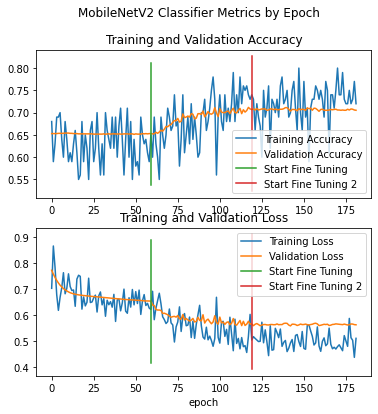

In [ ]:
acc = history.history['accuracy'].copy()
val_acc = history.history['val_accuracy'].copy()
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']
acc += history_fine2.history['accuracy']
val_acc += history_fine2.history['val_accuracy']

loss = history.history['loss'].copy()
val_loss = history.history['val_loss'].copy()
loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']
loss += history_fine2.history['loss']
val_loss += history_fine2.history['val_loss']

fig = plt.figure(figsize=(6, 6))
plt.suptitle('MobileNetV2 Classifier Metrics by Epoch')

plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
#plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.plot([initial_epochs+fine_tune_epochs-1,initial_epochs+fine_tune_epochs-1],
          plt.ylim(), label='Start Fine Tuning 2')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
#plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.plot([initial_epochs+fine_tune_epochs-1,initial_epochs+fine_tune_epochs-1],
         plt.ylim(), label='Start Fine Tuning 2')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

fig.savefig(f'training_by_epoch{get_datetime_id()}.png',dpi=300)

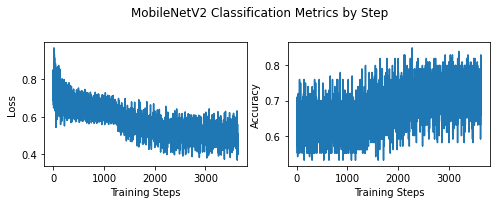

In [ ]:
fig2 = plt.figure(figsize=(8,5))
plt.suptitle('MobileNetV2 Classification Metrics by Step')

plt.subplot(2, 2, 1)
plt.ylabel("Loss")
plt.xlabel("Training Steps")
#plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

plt.subplot(2, 2, 2)
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
#plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)
plt.show()

fig2.savefig(f'training_by_steps{get_datetime_id()}.png',dpi=300)

Train from Scratch

In [11]:
# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights=None) # use None for randomization

In [12]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  #tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
])
# go from 0,255 to -1,1
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1)

In [13]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
#x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [14]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics='accuracy')

In [ ]:
#batch_stats_callback = CollectBatchStats()
initial_epochs = 200
history_baseline = model.fit(train_dataset,
                    epochs=initial_epochs,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=valid_dataset)

Epoch 1/200
20/20 [==============================] - 79s 1s/step - loss: 0.6899 - accuracy: 0.6509 - val_loss: 0.6758 - val_accuracy: 0.6529
Epoch 2/200
20/20 [==============================] - 16s 805ms/step - loss: 0.6669 - accuracy: 0.6639 - val_loss: 0.6469 - val_accuracy: 0.6529
Epoch 3/200
20/20 [==============================] - 16s 794ms/step - loss: 0.6550 - accuracy: 0.6383 - val_loss: 0.6456 - val_accuracy: 0.6529
Epoch 4/200
20/20 [==============================] - 16s 803ms/step - loss: 0.6556 - accuracy: 0.6368 - val_loss: 0.6461 - val_accuracy: 0.6529
Epoch 5/200
20/20 [==============================] - 16s 831ms/step - loss: 0.6679 - accuracy: 0.6146 - val_loss: 0.6475 - val_accuracy: 0.6529
Epoch 6/200
20/20 [==============================] - 16s 785ms/step - loss: 0.6574 - accuracy: 0.6333 - val_loss: 0.6469 - val_accuracy: 0.6529
Epoch 7/200
20/20 [==============================] - 16s 794ms/step - loss: 0.6731 - accuracy: 0.6038 - val_loss: 0.6477 - val_accuracy: 0.